In [22]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import pickle

df = pd.read_csv("cross_validated_simone.csv")
df['timestamp'] = df['timestamp'].apply(datetime.fromtimestamp)

In [23]:
df

,timestamp,sequence_id,interacted,lstm_proba,rf_proba
0,2023-08-25 16:36:23.146510,1,True,0.450617,0.45
1,2023-08-25 16:36:23.346570,1,True,0.552707,0.61
2,2023-08-25 16:36:23.546630,1,True,0.673371,0.54
3,2023-08-25 16:36:23.746702,1,True,0.794092,0.48
4,2023-08-25 16:36:23.946760,1,True,0.845505,0.51
...,...,...,...,...,...
3544,2023-08-25 15:13:01.960419,10051,True,0.998367,0.99
3545,2023-08-25 15:13:02.160609,10051,True,0.997822,0.14
3546,2023-08-25 15:13:02.360674,10051,True,0.997964,0.96
3547,2023-08-25 15:13:02.560738,10051,True,0.997113,0.30


In [24]:
def compute_metrics(seq, pred_col='lstm_proba', window_size=7):
    metrics = {
               'th':[], 
               'detection':[], 
               'label':[], 
               'ts_detection':[], 
               'time_to_detect':[],
               'anticipation':[],
               'ts_interact':[],
              }
    label = np.any(seq['interacted'])
    if label:
        ts_interact = seq['timestamp'].iloc[-1]#seq.loc[seq['start_label'], 'timestamp'].iloc[0]
    else:
        ts_interact = pd.NaT
    
    for th in np.linspace(0, 1, num=99):
        #for model in [f'{m_name}_{i}_pred' for m_name in m_names for i in features_d]:
        pred_avg = seq[pred_col].rolling(window_size).mean()
        pred = pred_avg >=th

        #detection = np.sum(pred) > 10
        detection = np.any(pred)

        ts_detection = pd.NaT
        time_to_detect = np.nan
        delay = np.nan    
        distance = np.nan
        if detection:
            detect_idx = pred.idxmax() # get first true idx
            ts_detection = seq.loc[detect_idx, 'timestamp']
            time_to_detect = (ts_detection - seq['timestamp'].min()).total_seconds()
            if label:
                delay = (ts_detection-ts_interact).total_seconds()

        metrics[f'th'].append(th)
        metrics[f'detection'].append(detection)
        metrics[f'label'].append(label)
        metrics[f'ts_detection'].append(ts_detection)
        metrics[f'time_to_detect'].append(time_to_detect)
        metrics[f'anticipation'].append(delay)
        metrics[f'ts_interact'].append(ts_interact)


    return pd.DataFrame(metrics)

In [25]:
from functools import partial

metrics = df.groupby(['sequence_id']).apply(partial(compute_metrics, pred_col='lstm_proba', window_size=7))

In [26]:
metrics

th  detection  label               ts_detection  \
sequence_id                                                             
1           0   0.000000       True   True 2023-08-25 16:36:24.346921   
            1   0.010204       True   True 2023-08-25 16:36:24.346921   
            2   0.020408       True   True 2023-08-25 16:36:24.346921   
            3   0.030612       True   True 2023-08-25 16:36:24.346921   
            4   0.040816       True   True 2023-08-25 16:36:24.346921   
...                  ...        ...    ...                        ...   
10051       94  0.959184       True   True 2023-08-25 15:13:01.360221   
            95  0.969388       True   True 2023-08-25 15:13:01.360221   
            96  0.979592       True   True 2023-08-25 15:13:01.560285   
            97  0.989796       True   True 2023-08-25 15:13:01.760356   
            98  1.000000      False   True                        NaT   

                time_to_detect  anticipation                ts_interact  
sequence_id                                                              
1           0         1.200411     -7.203185 2023-08-25 16:36:31.550106  
            1         1.200411     -7.203185 2023-08-25 16:36:31.550106  
            2         1.200411     -7.203185 2023-08-25 16:36:31.550106  
            3         1.200411     -7.203185 2023-08-25 16:36:31.550106  
            4         1.200411     -7.203185 2023-08-25 16:36:31.550106  
...                        ...           ...                        ...  
10051       94        4.001482     -1.600622 2023-08-25 15:13:02.960843  
            95        4.001482     -1.600622 2023-08-25 15:13:02.960843  
            96        4.201546     -1.400558 2023-08-25 15:13:02.960843  
            97        4.401617     -1.200487 2023-08-25 15:13:02.960843  
            98             NaN           NaN 2023-08-25 15:13:02.960843  

[13266 rows x 7 columns]

In [27]:
with open('metrics_simone.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [31]:
from datetime import timedelta
def f(ttdf):    
    ret = {'recall': [], 
           'precision': [], 
           'fpr': [], 
           'anticipation': [],
           'accuracy': [],
           'f1': []
          }
    dts = []
    tp_m = ttdf["detection"] & ttdf["label"]
    tp = (tp_m).sum()
    fp_m = ttdf["detection"] & ~ttdf["label"]
    fp = (fp_m).sum()
    tn_m = ~ttdf["detection"] & ~ttdf["label"]
    tn = (tn_m).sum()
    fn_m = ~ttdf["detection"] & ttdf["label"]
    fn = (fn_m).sum()
    
    recall = tp/(tp+fn)
    ret['recall'].append(recall)
    precision = tp/(tp+fp) if (tp+fp) else np.nan
    ret['precision'].append(precision) # to avoid print divide by 0 error
    
    ret['fpr'].append(fp/(fp+tn))
    
    #Accuracy = (TP+TN)/(TP+FP+FN+TN)
    ret['accuracy'].append((tp+tn)/(tp+tn+fp+fn))
    ret['anticipation'].append(ttdf[tp_m]['anticipation'].abs().mean())
    ret['f1'].append(2*(precision*recall)/(precision+recall))
    dts.append(0)
#     for dt in [1, 2, 3, 4]:
#         start_ts = (ttdf['ts_interact']-timedelta(seconds=dt)) # note NaT-val=NaT
#         tp = (tp_m & (ttdf['ts_detection']<=start_ts)).sum() # note NaT compared to something, even NaT is False
#         fp = fp_m.sum()
#         tn = tn_m.sum()
#         fn = (fn_m | (tp_m & (ttdf['ts_detection']>start_ts))).sum()
        
#         assert len(ttdf)-tp-fp-tn == fn
        
#         recall = tp/(tp+fn)
#         ret['recall'].append(recall)
#         precision = tp/(tp+fp) if (tp+fp) else np.nan
#         ret['precision'].append(precision) # to avoid print divide by 0 error     
#         ret['fpr'].append(fp/(fp+tn))
#         ret['accuracy'].append((tp+tn)/(tp+tn+fp+fn))
#         ret['f1'].append(2*(precision*recall)/(precision+recall))
#         delay_mask = tp_m & (ttdf['ts_detection']<=start_ts)
#         delay = (ttdf[delay_mask]['ts_detection']-ttdf[delay_mask]['ts_interact']).abs().mean().total_seconds()
#         ret['anticipation'].append(delay)
#         dts.append(dt)
    
    ret = pd.DataFrame(ret, index=dts)
    ret.index.name = "dt"
    return ret

tab = metrics.groupby(["th"]).apply(f)


In [32]:
import matplotlib.pyplot as plt

def plot_metrics(tab, axes):
#         print(len(tab.recall))
#         display(tab)
#         ax.plot('recall', 'precision', data=g, label=f"PR-Curve dt={n}s")
#         ax.plot(range(len(g.precision)), g.precision)
#         ax.plot(range(len(g.recall)), g.recall)
#         ax.plot(range(len(tab.anticipation)), tab.anticipation)
#         ax.plot(tab.th, tab.anticipation)
        axes[0].plot(tab.th, tab.precision.fillna(1), label='precision')
        axes[0].plot(tab.th, tab.recall, label='recall')
        axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[0].legend()
        axes[1].plot('fpr', 'recall', data=tab, label=f"ROC-Curve")
        axes[1].set(xlabel="FPR", ylabel="TPR", xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[1].plot([0, 1], [0, 1], 'k--')
        axes[1].legend()
        axes[2].plot(tab.th, tab.anticipation, label="Mean Anticipation")
        axes[2].set(xlabel="Threshold", ylabel="Anticipation [s]")#, xlim=[0, 1])
        
        axes[3].plot(tab.th, tab.accuracy, label='accuracy')
        axes[3].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
        axes[3].legend()
        
        
#         ax[0].plot(tab.th, tab.recall)
#         ax.plot(g.precision, g.recall, g.index.get_level_values(0))
#         axes[1, 1].plot('fpr', 'recall', data=g, label=f"ROC-Curve dt={n}s")
#         axes[1, 1].set(xlabel="FPR", ylabel="TPR", xlim=[0, 1], ylim=[0, 1])
#         axes[1, 1].legend()


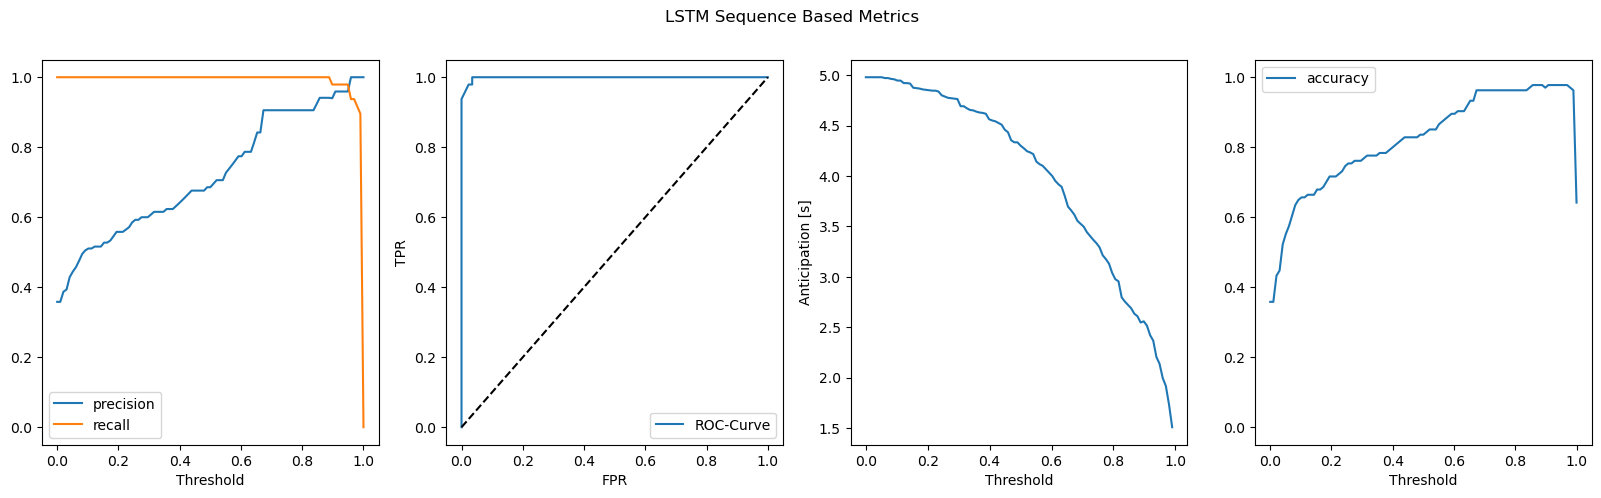

In [33]:
dt=0
to_plot = tab.reset_index(0)
fig,axes= plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle(f"LSTM Sequence Based Metrics")
plot_metrics(to_plot.xs(dt), axes)

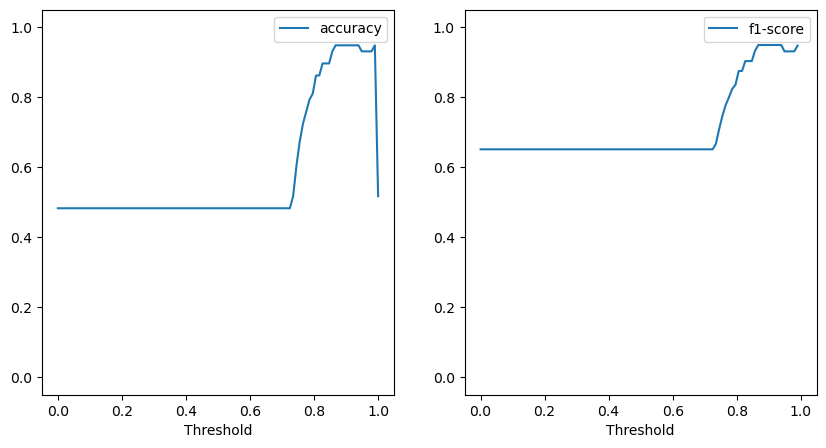

In [37]:
dt=0
to_plot = tab.reset_index(0)
fig,axes= plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(to_plot.xs(dt).th, to_plot.xs(dt).accuracy, label='accuracy')
axes[0].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axes[0].legend()

axes[1].plot(to_plot.xs(dt).th, to_plot.xs(dt).f1, label='f1-score')
axes[1].set(xlabel='Threshold', xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
axes[1].legend()
plt.show()

In [38]:
# AUROC
np.trapz(to_plot.xs((dt)).recall, to_plot.xs((dt)).th)

0.993075801749271

In [15]:
import matplotlib.pyplot as plt

def plot_metrics(tab, axd):
    last_p = tab.precision.isna().values.argmax()+10
    
    axd['left'].plot('fpr', 'recall', data=tab, label=f"ROC-Curve")
    axd['left'].set_xlabel("False positive rate", fontsize=label_size)
    axd['left'].set_ylabel("True positive rate", fontsize=label_size)
    axd['left'].set(xlim=[0, 1.], ylim=[0, 1.025])
    axd['left'].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axd['left'].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    axd['left'].set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, ""])
    
#     axd['left'].set_box_aspect(1)
    display(tab)
    xlim_right = [0.65, 1.]
    tab = tab[tab.th>=0.5]
    axd['upper right'].plot(tab.th, tab.precision.fillna(1), label='precision')
    axd['upper right'].plot(tab.th, tab.recall, label='recall')
    axd['upper right'].yaxis.tick_right()
    axd['upper right'].set_ylabel("Precision, Recall", fontsize=label_size)
    axd['upper right'].yaxis.set_label_position("right")
    axd['upper right'].set(xlim=xlim_right)
    
#     axd['upper right'].set_ylabel("True Positive Rate", fontsize=6)
#     axd['upper right'].set(xlabel='Threshold', )#xlim=[-0.05, 0.77], ylim=[0.1, 1.05])
#     axd['upper right'].set_box_aspect(1)
#     axd['upper right'].legend()
    axd['upper right'].set_xticklabels([])
    # for minor ticks
#     axd['upper right'].set_xticks([], minor=True)
#     axd['left'].legend()
    axd['lower right'].plot(tab.th, tab.anticipation, label="Mean Anticipation")
    axd['lower right'].set(ylim=[0, 7.], xlim=xlim_right)
    axd['lower right'].set_ylabel("Advance detection [s]", fontsize=label_size)
    axd['lower right'].set_xlabel("Threshold", fontsize=label_size)
    axd['lower right'].set_yticks([0, 3, 6])
#     axd['lower right'].set_xticks([0.7, 0.75, 0.8, 0.85, 0.9])
    axd['lower right'].yaxis.tick_right()
    axd['lower right'].yaxis.set_label_position("right")
#     axd['lower right'].set_box_aspect(1)

,th,recall,precision,fpr,anticipation
dt,,,,,
0,0.000000,1.000000,0.482759,1.000000,6.274096
0,0.010204,1.000000,0.482759,1.000000,6.274096
0,0.020408,1.000000,0.482759,1.000000,6.274096
0,0.030612,1.000000,0.482759,1.000000,6.274096
0,0.040816,1.000000,0.482759,1.000000,6.274096
...,...,...,...,...,...
0,0.959184,0.964286,0.900000,0.100000,2.665268
0,0.969388,0.964286,0.900000,0.100000,2.559036
0,0.979592,0.964286,0.900000,0.100000,2.418269


<Figure size 350x350 with 0 Axes>

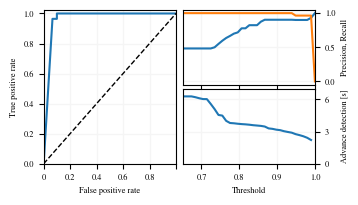

In [16]:
from matplotlib.patches import Rectangle
import matplotlib as mpl
#import colorcet as cc
#import skimage

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
label_size = 6 # anche 7 se serve
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

fig = plt.figure(figsize=(3.5, 3.5),)
fig = plt.figure(figsize=(3.5, 2.),)

axd = fig.subplot_mosaic([['left', 'upper right'],
                               ['left', 'lower right']])
# axd['upper right'].get_shared_x_axes().join(axd['upper right'], axd['lower right'])

# dt=0
# to_plot = tab.reset_index(-2).sort_index()

dt=0
to_plot = tab.reset_index(0)
# fig,axes= plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle(f"LSTM Sequence Based Metrics")
# plot_metrics(to_plot.xs(dt), axes)
# fig,axes= plt.subplots(1, 3, figsize=(15, 5))
# fig.suptitle(f"Model {model}, Features Set {feat}")
plot_metrics(to_plot.xs((dt)), axd)
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for ax in axd.values():
    plt.sca(ax)
    plt.grid(linestyle='-',linewidth=1,color='whitesmoke')
fig.align_ylabels()
# fig.tight_layout()
# plt.savefig("images/sequence_based.pdf",  bbox_inches='tight')
plt.savefig("sequence_based.svg",  bbox_inches='tight')

0.993075801749271